In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Data Preparation - MNIST

In [2]:
# Loading data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(f"Train images: {train.shape[0]}\nTest images: {test.shape[0]}")

Train images: 42000
Test images: 28000


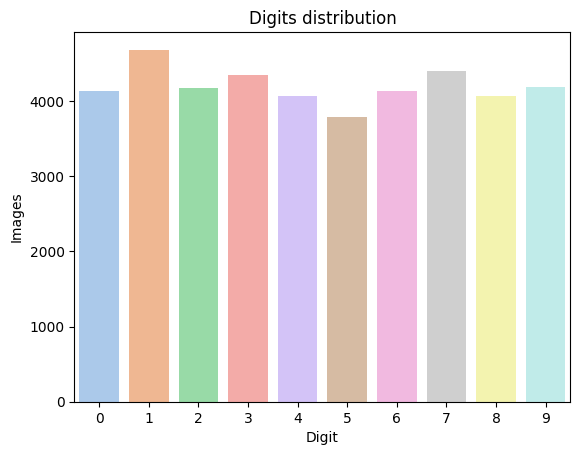

In [3]:
Y_train = train["label"]
X_train = train.drop("label", axis=1)

# Digits distribution
sns.countplot(x=Y_train, hue=Y_train, palette=("pastel"), legend=False)
plt.xlabel("Digit")
plt.ylabel("Images")
plt.title("Digits distribution")
plt.show()

In [4]:
# Checking nulls
print("Train Nulls:", X_train.isnull().values.sum())
print("Test Nulls:", test.isnull().values.sum())

Train Nulls: 0
Test Nulls: 0


In [5]:
# Normalization
X_train = X_train / 255.0
test = test / 255.0

In [6]:
# Reshape
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [7]:
# Label Encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [8]:
# Split Training and Validation Set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

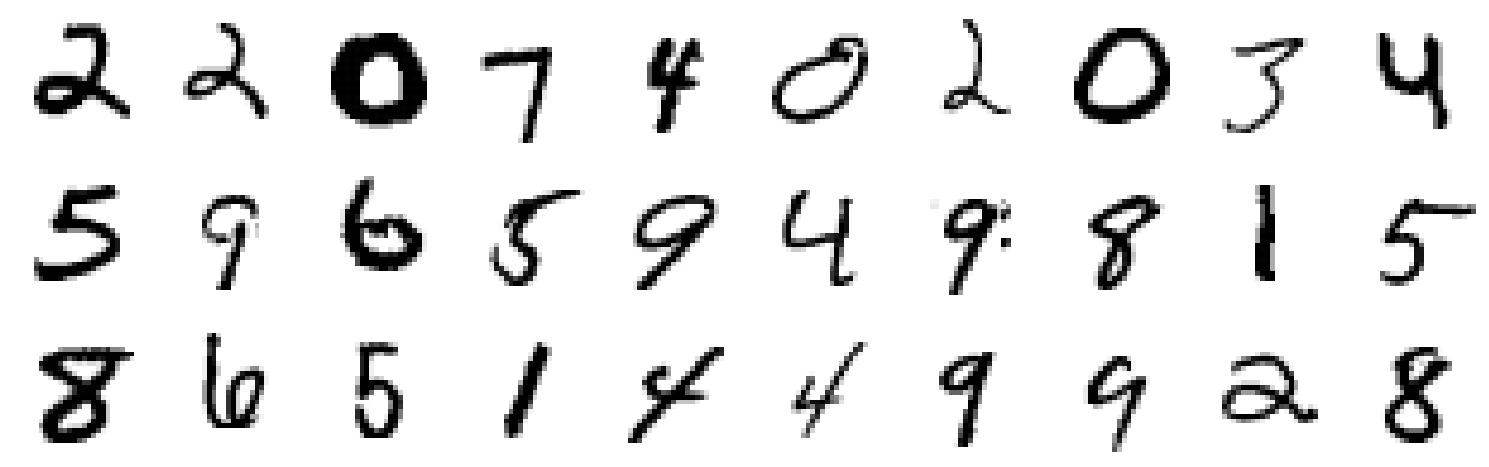

In [ ]:
# Plotting example digits
plt.figure(figsize=(15,5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap="binary")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1,
                            horizontal_flip=False, vertical_flip=False)

### CNN

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='Same', use_bias=False, input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), padding='Same', use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        288       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18432     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

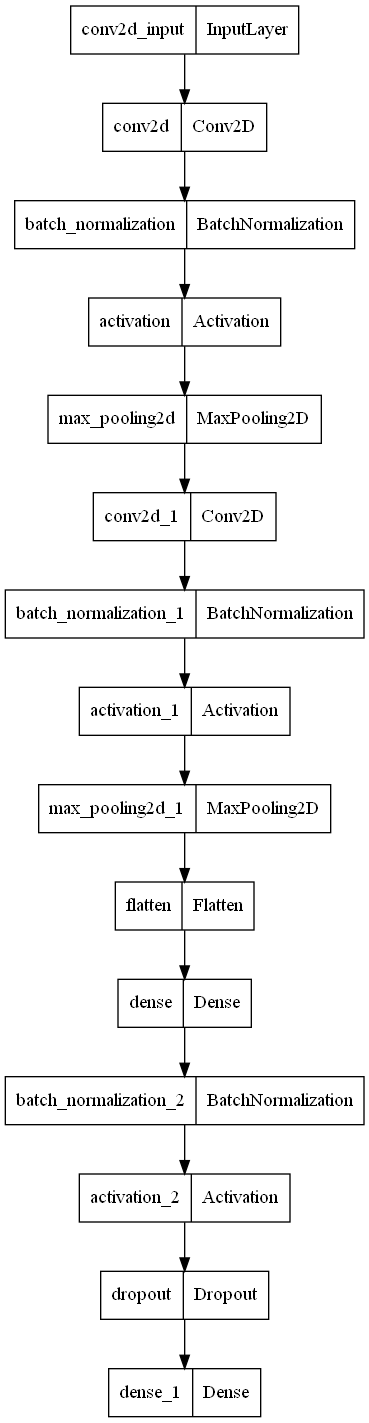

In [13]:
plot_model(model)

In [ ]:
epochs = 100
batch_size = 128

train_gen = datagen.flow(X_train, Y_train, batch_size=batch_size)

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights=True) 

rlr = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor = 0.5, min_lr = 1e-6)

mc = ModelCheckpoint('best_model.h5', monitor = 'val_loss', save_best_only = True, mode = 'min')

learning_hist = model.fit(train_gen, epochs = epochs, validation_data = (X_val, Y_val),
                                    callbacks=[es, rlr, mc])

model.save('best_model.h5')

Epoch 1/100
296/296 [==============================] - 14s 24ms/step - loss: 0.2895 - accuracy: 0.9114 - val_loss: 5.6090 - val_accuracy: 0.1126 - lr: 0.0010
Epoch 2/100
296/296 [==============================] - 9s 30ms/step - loss: 0.1212 - accuracy: 0.9639 - val_loss: 0.4056 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 3/100
296/296 [==============================] - 7s 22ms/step - loss: 0.0914 - accuracy: 0.9727 - val_loss: 0.0370 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 4/100
296/296 [==============================] - 7s 22ms/step - loss: 0.0793 - accuracy: 0.9760 - val_loss: 0.0563 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 5/100
296/296 [==============================] - 7s 22ms/step - loss: 0.0703 - accuracy: 0.9788 - val_loss: 0.0485 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 6/100
296/296 [==============================] - 6s 22ms/step - loss: 0.0577 - accuracy: 0.9824 - val_loss: 0.0317 - val_accuracy: 0.9905 - lr: 5.0000e-04
Epoch 7/100
296/296 [==============================] 

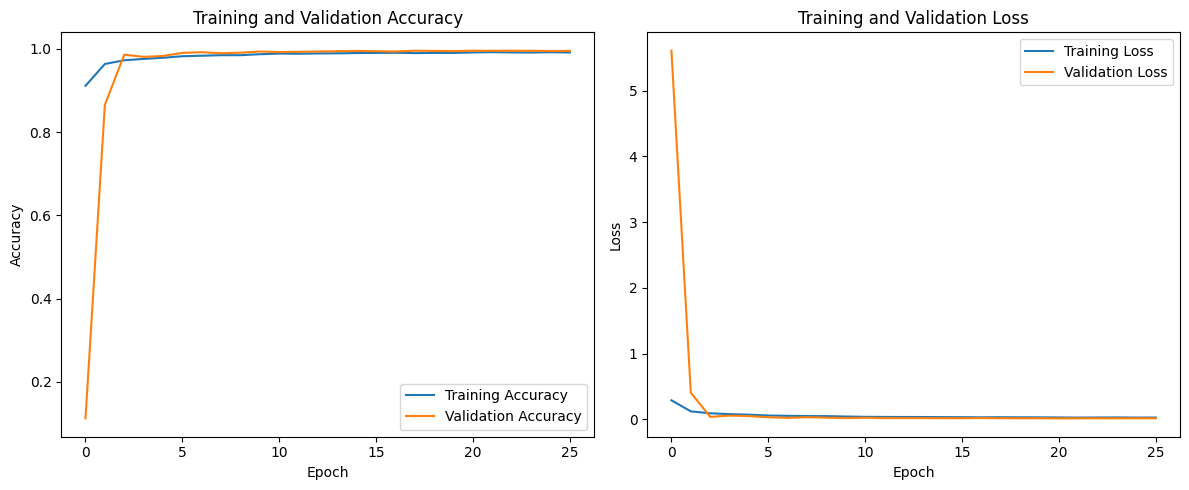

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(learning_hist.history['accuracy'], label='Training Accuracy')
plt.plot(learning_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(learning_hist.history['loss'], label='Training Loss')
plt.plot(learning_hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# model = load_model('best_model.h5')

results = model.predict(test)

results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1, len(results) + 1), name="ImageId"), results], axis=1)
submission.to_csv("CNN_keras_submission.csv", index=False)

### Conclusions and Insights